In [ ]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import numpy as np
import pandas as pd

from util import engineer_features, prep_X_y

DATA_DIR = Path("./pistachio_1_data")
dyads_df = pd.read_csv(DATA_DIR / "all_dyads.csv")

sorted_dyads_df = dyads_df.sort_values(
    by="ActivityDateTime", key=lambda x: pd.to_datetime(x)
)
cleaned_dyads_dfs = engineer_features(sorted_dyads_df)

In [120]:
import pickle
from typing import Any, Literal

from flaml import AutoML
from sklearn.metrics import (
    balanced_accuracy_score,
    fbeta_score,
    make_scorer,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import (
    FixedThresholdClassifier,
    KFold,
    PredefinedSplit,
    StratifiedGroupKFold,
    StratifiedKFold,
    TimeSeriesSplit,
    TunedThresholdClassifierCV,
)
from tqdm.auto import tqdm
from xgboost import XGBClassifier

from hr_model import HrModel
from util import FeatureSetDataFrames


def specificity_score(y_true, y_pred) -> float:
    tn = ((y_true == 0) & (y_pred == 0)).sum()
    fp = ((y_true == 0) & (y_pred == 1)).sum()
    if (tn + fp) == 0:
        return float("nan")
    return tn / (tn + fp)


def find_threshold_ref_specificity(model, X, y, *, verbose=False) -> float:
    hr_model = HrModel()

    ref_y_pred = hr_model.predict(X)
    ref_specificity = specificity_score(y, ref_y_pred)
    ref_recall = recall_score(y, ref_y_pred, zero_division=np.nan)

    y_pred_proba = model.predict_proba(X)
    thresholds = np.logspace(-5, 0, 100)

    for th in thresholds:
        y_pred = (y_pred_proba[:, 1] >= th).astype(int)
        specificity = specificity_score(y, y_pred)
        recall = recall_score(y, y_pred, zero_division=np.nan)
        if specificity >= ref_specificity:
            if verbose:
                print(f"Selected threshold: {th}")
                print(f"Selected specificity: {specificity}, recall: {recall}")
                print(f"Reference specificity: {ref_specificity}, recall: {ref_recall}")
            return th

    raise ValueError("No suitable threshold found!")


def find_threshold_ref_specificity_cv(model, df_train, df_val, cv, verbose=False):
    X, y = prep_X_y(pd.concat([df_train, df_val]), "tantrum_within_60m")
    thresholds = []
    for train_idx, val_idx in cv.split(df_train):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model.fit(X_tr, y_tr)
        th: int | float = find_threshold_ref_specificity(
            model, X_val, y_val, verbose=verbose
        )
        thresholds.append(th)

    best_threshold = float(np.mean(thresholds))
    if verbose:
        print(f"Cross-validated best threshold: {best_threshold:.4f}")

    model.fit(X, y)
    return FixedThresholdClassifier(model, threshold=best_threshold)


def youdens_j_score(y_true, y_pred) -> float:
    sensitivity = recall_score(y_true, y_pred, zero_division=np.nan)
    specificity = specificity_score(y_true, y_pred)
    return sensitivity + specificity - 1


TuningMethod = (
    Literal["ref_specificity"] | Literal["balanced_accuracy"] | Literal["youden_index"]
)


def create_dyad_cv(df_train: pd.DataFrame, n_splits: int = 5) -> PredefinedSplit:
    # Create 5-fold CV based on "dyad"
    dyad_labels = df_train["dyad"]
    skf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    folds = np.zeros(len(df_train), dtype=int)
    for fold_idx, (_, val_idx) in enumerate(
        skf.split(np.zeros(len(dyad_labels)), dyad_labels)
    ):
        folds[val_idx] = fold_idx
    return PredefinedSplit(folds)


def train_model(
    df_train,
    df_val,
    hyperparams: dict[str, Any],
    tuning_method: TuningMethod,
):
    model = XGBClassifier(**hyperparams)
    X_train, y_train = prep_X_y(pd.concat([df_train, df_val]), "tantrum_within_60m")
    cv = (
        create_dyad_cv(df_train)
        if len(df_val) == 0
        else PredefinedSplit(test_fold=[-1] * len(df_train) + [0] * len(df_val))
    )

    thresholds = np.logspace(-5, 0, 100)
    if tuning_method == "balanced_accuracy":
        tuned_model = TunedThresholdClassifierCV(
            model,
            scoring="balanced_accuracy",
            thresholds=thresholds,
            cv=cv,
            n_jobs=-1,
        )
        tuned_model.fit(X_train, y_train)
        return tuned_model
    elif tuning_method == "youden_index":
        tuned_model = TunedThresholdClassifierCV(
            model,
            scoring=make_scorer(youdens_j_score),
            thresholds=thresholds,
            cv=cv,
            n_jobs=-1,
        )
        tuned_model.fit(X_train, y_train)
        return tuned_model
    elif tuning_method == "ref_specificity":
        return find_threshold_ref_specificity_cv(
            model, df_train, df_val, cv, verbose=False
        )
    else:
        raise ValueError(f"Unknown tuning method: {tuning_method}")


def bootstrap(df: pd.DataFrame, n_samples: int) -> pd.DataFrame:
    boot_df = pd.DataFrame()
    for _ in range(n_samples):
        boot_df = pd.concat(
            [
                boot_df,
                df.sample(frac=1, replace=True, random_state=None),
            ]
        )
    return boot_df


def train_and_get_dyad_models(
    df_population: pd.DataFrame,
    df_test: pd.DataFrame,
    mode: str,
    week: int,
    dyad_models: dict[str, TunedThresholdClassifierCV],
    tuning_method: TuningMethod,
):
    min_week = df_test["therapy_week"].min()
    if week == min_week:
        return dyad_models

    new_dyad_models = {}
    bootstrap_level = df_test["dyad"].nunique()
    match mode:
        case "no_retrain":
            return dyad_models
        case "retrain_dyad":
            for dyad, dyad_df in tqdm(df_test.groupby("dyad"), leave=False):
                add_df = dyad_df[dyad_df["therapy_week"] < week]
                add_df = bootstrap(add_df, bootstrap_level)

                df_train = pd.concat(
                    [df_population, add_df[add_df["therapy_week"] < week - 1]]
                )
                df_val = add_df[add_df["therapy_week"] == week - 1]
                new_dyad_models[dyad] = train_model(
                    df_train,
                    df_val,
                    dyad_models[dyad].estimator.get_params(),
                    tuning_method,
                )
        case _:
            raise ValueError(f"Unknown mode: {mode}")

    return new_dyad_models


def retrain_and_predict(
    base_model,
    df_train: pd.DataFrame,
    df_test: pd.DataFrame,
    mode: str,
    tuning_method: TuningMethod,
):
    dyad_models = {d: base_model for d in df_test["dyad"].unique()}
    weekly_results = []
    weekly_models = []
    weeks = df_test["therapy_week"].unique()
    weeks_iter = sorted(weeks[weeks >= 0])
    for week in tqdm(weeks_iter):
        dyad_models = train_and_get_dyad_models(
            df_train,
            df_test,
            mode,
            week,
            dyad_models=dyad_models,
            tuning_method=tuning_method,
        )
        weekly_models.append((week, dyad_models))
        week_df = df_test[df_test["therapy_week"] == week]

        week_pred_proba = np.empty((0, 2))
        week_preds = np.array([])
        week_trues = np.array([])
        week_thresholds = np.array([])

        for dyad, dyad_week_df in week_df.groupby("dyad"):
            X, y = prep_X_y(dyad_week_df, "tantrum_within_60m")
            model = dyad_models[dyad]

            y_pred_proba = model.predict_proba(X)
            y_pred = model.predict(X)

            week_pred_proba = np.concatenate([week_pred_proba, y_pred_proba])
            week_preds = np.concatenate([week_preds, y_pred])
            week_trues = np.concatenate([week_trues, y.values])
            threshold = (
                model.best_threshold_
                if isinstance(model, TunedThresholdClassifierCV)
                else 0.5
            )
            week_thresholds = np.append(week_thresholds, threshold)

        print(
            f"Week {week} sensitivity: {recall_score(week_trues, week_preds)}, specificity: {specificity_score(week_trues, week_preds)}"
        )
        weekly_results.append(
            (week, week_pred_proba, week_preds, week_trues, week_thresholds)
        )

    return weekly_results, weekly_models


supersets_to_test = [
    ["watch"],
    ["watch", "demographic"],
    ["watch", "medical"],
    ["watch", "demographic", "medical"],
]


automl_settings = {
    # "max_iter": 25,
    "time_budget": 15,
    # "train_time_limit": 1,  # seconds
    "task": "classification",
    "metric": "log_loss",
    "estimator_list": ["xgboost"],
    "early_stop": True,
}


def eval_model_on_feature_sets(
    supersets_to_test: list[list[str]],
    dfs: FeatureSetDataFrames,
    weeks: tuple[int, int],
    mode: str,
    tuning_method: TuningMethod,
    verbose: bool = False,
) -> dict[str, Any]:
    feature_supersets = {
        "watch": [
            "hr",
            "activity",
            "sleep",
            "stress",
            "overnight_hrv",
        ],
        "demographic": [
            "child_demo",
            "parent_demo",
        ],
        "medical": [
            "medical",
            "therapy",
        ],
    }
    feature_set_results = {}
    for supersets in supersets_to_test:
        features = [fs for superset in supersets for fs in feature_supersets[superset]]
        combined_df = pd.concat(
            [
                cleaned_dyads_dfs["index"],
                cleaned_dyads_dfs["response"],
            ]
            + [cleaned_dyads_dfs[fs] for fs in features],
            axis=1,
        )

        name = "_".join(supersets)
        print(f"Feature sets: {name}")

        combined_df = combined_df[
            (combined_df["therapy_week"].between(weeks[0], weeks[1]))
        ]
        df_train = combined_df[combined_df["Arm_Sham"]]
        df_test = combined_df[~combined_df["Arm_Sham"]]

        # Create 5-fold CV based on "dyad"
        dyad_labels = df_train["dyad"]
        skf = KFold(n_splits=5, shuffle=True, random_state=42)
        folds = np.zeros(len(df_train), dtype=int)
        for fold_idx, (_, val_idx) in enumerate(
            skf.split(np.zeros(len(dyad_labels)), dyad_labels)
        ):
            folds[val_idx] = fold_idx
        cv = PredefinedSplit(folds)
        X_train, y_train = prep_X_y(df_train, "tantrum_within_60m")

        automl = AutoML()
        automl.fit(
            X_train,
            y_train,
            **automl_settings,
            split_type=cv,
            verbose=verbose,
        )
        tuned_model = train_model(
            df_train,
            pd.DataFrame(),
            automl.best_config,
            tuning_method=tuning_method,
        )
        results, models = retrain_and_predict(
            tuned_model, df_train, df_test, mode=mode, tuning_method=tuning_method
        )

        data_dir = Path("./intermediate_data")
        data_dir.mkdir(parents=True, exist_ok=True)
        with open(data_dir / f"{tuning_method}_{mode}_{name}_results.pkl", "wb") as f:
            pickle.dump(results, f)

        feature_set_results[name] = results
    return feature_set_results

In [115]:
# Params
weeks = (0, 15)
tuning_method: TuningMethod = "balanced_accuracy"

In [116]:
full_df = pd.concat(list(cleaned_dyads_dfs.values()), axis=1)
full_df = full_df[full_df["therapy_week"].between(weeks[0], weeks[1])]
full_df_train = full_df[full_df["Arm_Sham"]]
full_df_test = full_df[~full_df["Arm_Sham"]]

X_train, y_train = prep_X_y(full_df_train, "tantrum_within_60m")

hr_model_results, _ = retrain_and_predict(
    HrModel(),
    full_df_train,
    full_df_test,
    mode="no_retrain",
    tuning_method=tuning_method,
)

  0%|          | 0/16 [00:00<?, ?it/s]

Week 0 sensitivity: 0.3163265306122449, specificity: 0.747796278158668
Week 1 sensitivity: 0.34210526315789475, specificity: 0.7520538637346347
Week 2 sensitivity: 0.28888888888888886, specificity: 0.7391064195409354
Week 3 sensitivity: 0.46296296296296297, specificity: 0.757537268533993
Week 4 sensitivity: 0.41935483870967744, specificity: 0.7602591792656588
Week 5 sensitivity: 0.15, specificity: 0.7517822423849644
Week 6 sensitivity: 0.25, specificity: 0.7327714427367378
Week 7 sensitivity: 0.75, specificity: 0.7363026603361218
Week 8 sensitivity: 0.39285714285714285, specificity: 0.7411065779113879
Week 9 sensitivity: 0.3611111111111111, specificity: 0.7435687122511371
Week 10 sensitivity: 0.45, specificity: 0.764197259470946
Week 11 sensitivity: 0.3333333333333333, specificity: 0.7487580362361193
Week 12 sensitivity: 0.3448275862068966, specificity: 0.7492137730828159
Week 13 sensitivity: 0.625, specificity: 0.7554823529411765
Week 14 sensitivity: 0.75, specificity: 0.7376130429244

In [121]:
no_retrain_results = eval_model_on_feature_sets(
    supersets_to_test=supersets_to_test,
    dfs=cleaned_dyads_dfs,
    weeks=weeks,
    mode="no_retrain",
    tuning_method=tuning_method,
    verbose=False,
)

Feature sets: watch


  0%|          | 0/16 [00:00<?, ?it/s]

Week 0 sensitivity: 0.10204081632653061, specificity: 0.8675930460333007
Week 1 sensitivity: 0.18421052631578946, specificity: 0.8426091790722096
Week 2 sensitivity: 0.2, specificity: 0.8653492082975328
Week 3 sensitivity: 0.35185185185185186, specificity: 0.8368874924794438
Week 4 sensitivity: 0.1935483870967742, specificity: 0.862955479690657
Week 5 sensitivity: 0.25, specificity: 0.8348671419313026
Week 6 sensitivity: 0.0, specificity: 0.8637297259012678
Week 7 sensitivity: 0.20833333333333334, specificity: 0.8534177405983873
Week 8 sensitivity: 0.4642857142857143, specificity: 0.8261398611409347
Week 9 sensitivity: 0.3055555555555556, specificity: 0.8504958616061442
Week 10 sensitivity: 0.1, specificity: 0.8581373195574119
Week 11 sensitivity: 0.3333333333333333, specificity: 0.8482612507305669
Week 12 sensitivity: 0.0, specificity: 0.8543665833400532
Week 13 sensitivity: 0.4375, specificity: 0.842635294117647
Week 14 sensitivity: 0.0, specificity: 0.8541587058973379
Week 15 sensit

  0%|          | 0/16 [00:00<?, ?it/s]

Week 0 sensitivity: 0.12244897959183673, specificity: 0.9028525954946132
Week 1 sensitivity: 0.13157894736842105, specificity: 0.9232812403483847
Week 2 sensitivity: 0.17777777777777778, specificity: 0.8945010433288327
Week 3 sensitivity: 0.12962962962962962, specificity: 0.8957818035964971
Week 4 sensitivity: 0.03225806451612903, specificity: 0.93255765345224
Week 5 sensitivity: 0.15, specificity: 0.9202203499675956
Week 6 sensitivity: 0.0, specificity: 0.934414618599051
Week 7 sensitivity: 0.08333333333333333, specificity: 0.9243349159695531
Week 8 sensitivity: 0.10714285714285714, specificity: 0.9124615274497173
Week 9 sensitivity: 0.2777777777777778, specificity: 0.9328909104466483
Week 10 sensitivity: 0.1, specificity: 0.9128746244595882
Week 11 sensitivity: 0.14285714285714285, specificity: 0.9304500292226768
Week 12 sensitivity: 0.034482758620689655, specificity: 0.9222643335214902
Week 13 sensitivity: 0.0, specificity: 0.9248
Week 14 sensitivity: 0.0, specificity: 0.88918609094

  0%|          | 0/16 [00:00<?, ?it/s]

Week 0 sensitivity: 0.22448979591836735, specificity: 0.8532688540646425
Week 1 sensitivity: 0.21052631578947367, specificity: 0.8827598986966458
Week 2 sensitivity: 0.3111111111111111, specificity: 0.8875046029213207
Week 3 sensitivity: 0.2962962962962963, specificity: 0.8838157630857678
Week 4 sensitivity: 0.12903225806451613, specificity: 0.8704103671706264
Week 5 sensitivity: 0.1, specificity: 0.8782890473104342
Week 6 sensitivity: 0.25, specificity: 0.8855443020043913
Week 7 sensitivity: 0.125, specificity: 0.8695455573140403
Week 8 sensitivity: 0.14285714285714285, specificity: 0.8500465249445279
Week 9 sensitivity: 0.05555555555555555, specificity: 0.8618298411751547
Week 10 sensitivity: 0.05, specificity: 0.8787279255514032
Week 11 sensitivity: 0.09523809523809523, specificity: 0.8782144944476914
Week 12 sensitivity: 0.0, specificity: 0.8611402306265624
Week 13 sensitivity: 0.0, specificity: 0.8324705882352941
Week 14 sensitivity: 1.0, specificity: 0.8497006750732391
Week 15 se

  0%|          | 0/16 [00:00<?, ?it/s]

Week 0 sensitivity: 0.5714285714285714, specificity: 0.7927277179236043
Week 1 sensitivity: 0.5263157894736842, specificity: 0.8119710914818704
Week 2 sensitivity: 0.6, specificity: 0.7944028476739904
Week 3 sensitivity: 0.5555555555555556, specificity: 0.8206430911157163
Week 4 sensitivity: 0.5806451612903226, specificity: 0.8118860168605866
Week 5 sensitivity: 0.3, specificity: 0.8057679844458846
Week 6 sensitivity: 0.4166666666666667, specificity: 0.8201714002408103
Week 7 sensitivity: 0.3333333333333333, specificity: 0.7933529278770065
Week 8 sensitivity: 0.42857142857142855, specificity: 0.7885620213298976
Week 9 sensitivity: 0.3888888888888889, specificity: 0.8076206099470584
Week 10 sensitivity: 0.6, specificity: 0.7845680369311937
Week 11 sensitivity: 0.2857142857142857, specificity: 0.8005552308591467
Week 12 sensitivity: 0.13793103448275862, specificity: 0.7914684299653254
Week 13 sensitivity: 0.6875, specificity: 0.7792
Week 14 sensitivity: 0.0, specificity: 0.80779518532671

In [ ]:
import warnings

warnings.filterwarnings("ignore")

test_case = [
    ["watch"],
    ["watch", "demographic"],
    ["watch", "medical"],
    ["watch", "demographic", "medical"],
]

retrain_dyad_results = eval_model_on_feature_sets(
    supersets_to_test=test_case,
    dfs=cleaned_dyads_dfs,
    weeks=weeks,
    mode="retrain_dyad",
    tuning_method=tuning_method,
    verbose=False,
)

# Analysis


In [73]:
from pathlib import Path

data_dir = Path("./intermediate_data")
retrain_dyad_results = {
    k: pickle.load(
        open(data_dir / f"balanced_accuracy_retrain_dyad_{k}_results.pkl", "rb")
    )
    for k in [
        "watch",
        "watch_demographic",
        "watch_medical",
        "watch_demographic_medical",
    ]
}

                                              AUROC  Sensitivity  Specificity
Model                                                                        
HR range (105-129)                            0.565        0.383        0.748
Watch - No Retrain                            0.612        0.296        0.788
Watch, Demographic - No Retrain               0.586        0.360        0.729
Watch, Medical - No Retrain                   0.640        0.245        0.842
Watch, Demographic, Medical - No Retrain      0.716        0.407        0.836
Watch - Retrain Weekly                        0.664        0.532        0.863
Watch, Demographic - Retrain Weekly           0.790        0.454        0.860
Watch, Medical - Retrain Weekly               0.771        0.490        0.879
Watch, Demographic, Medical - Retrain Weekly  0.804        0.462        0.878


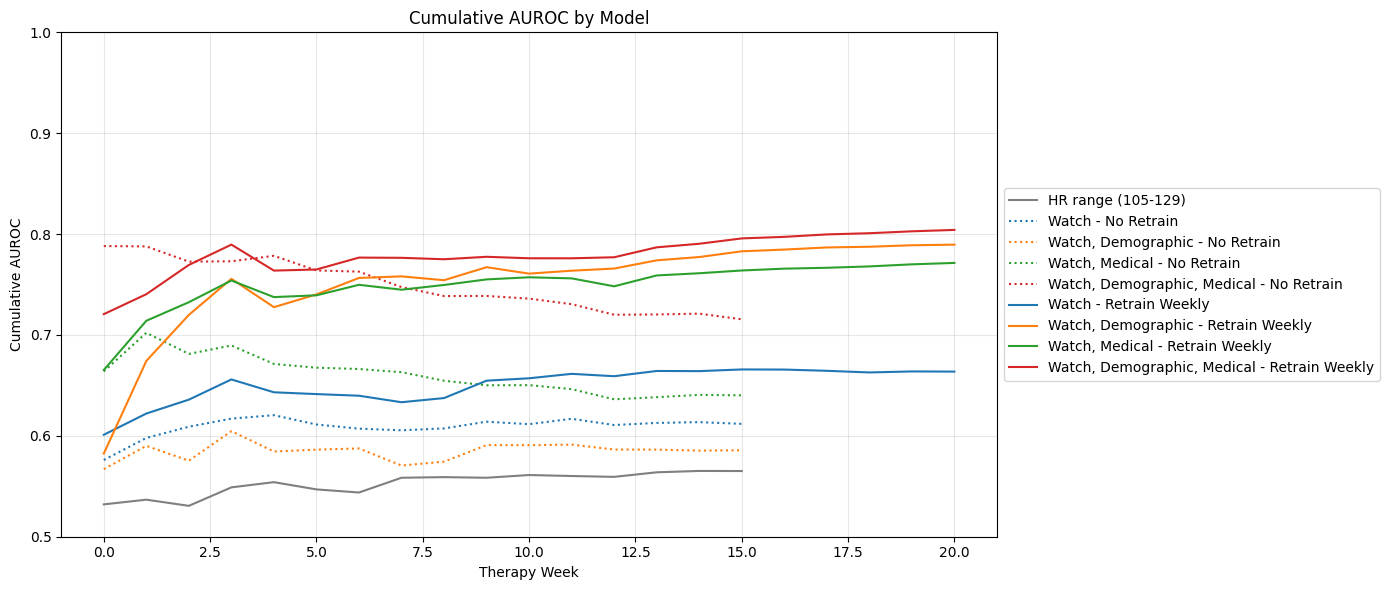

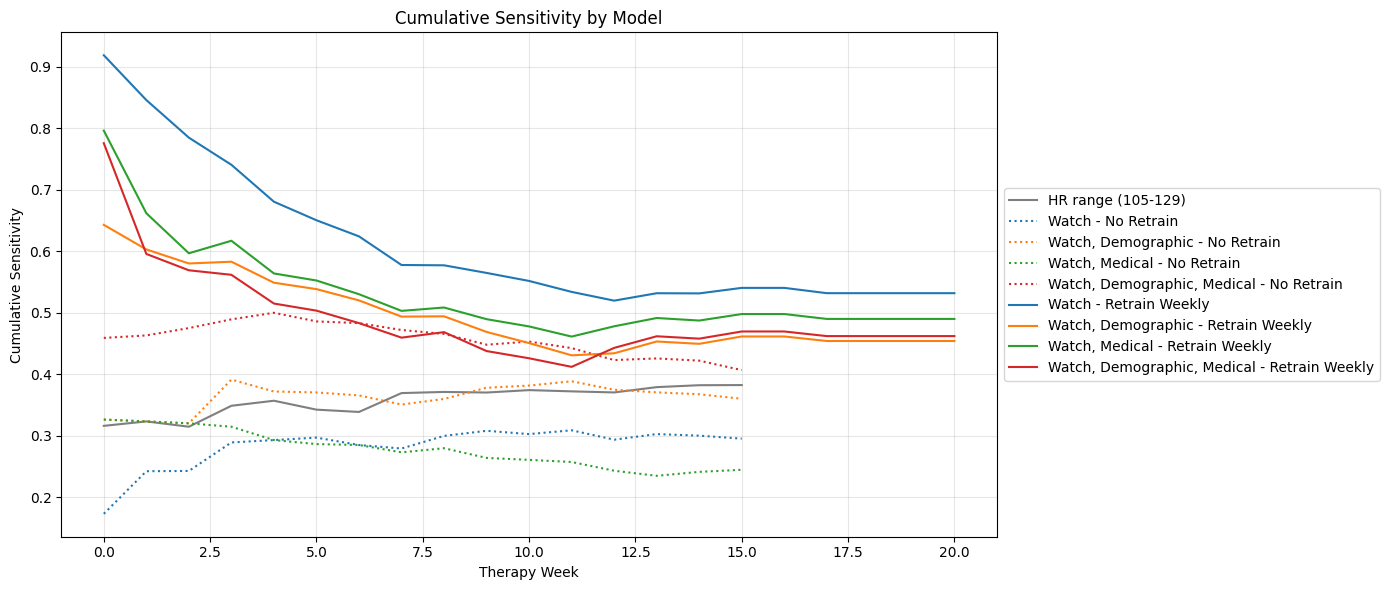

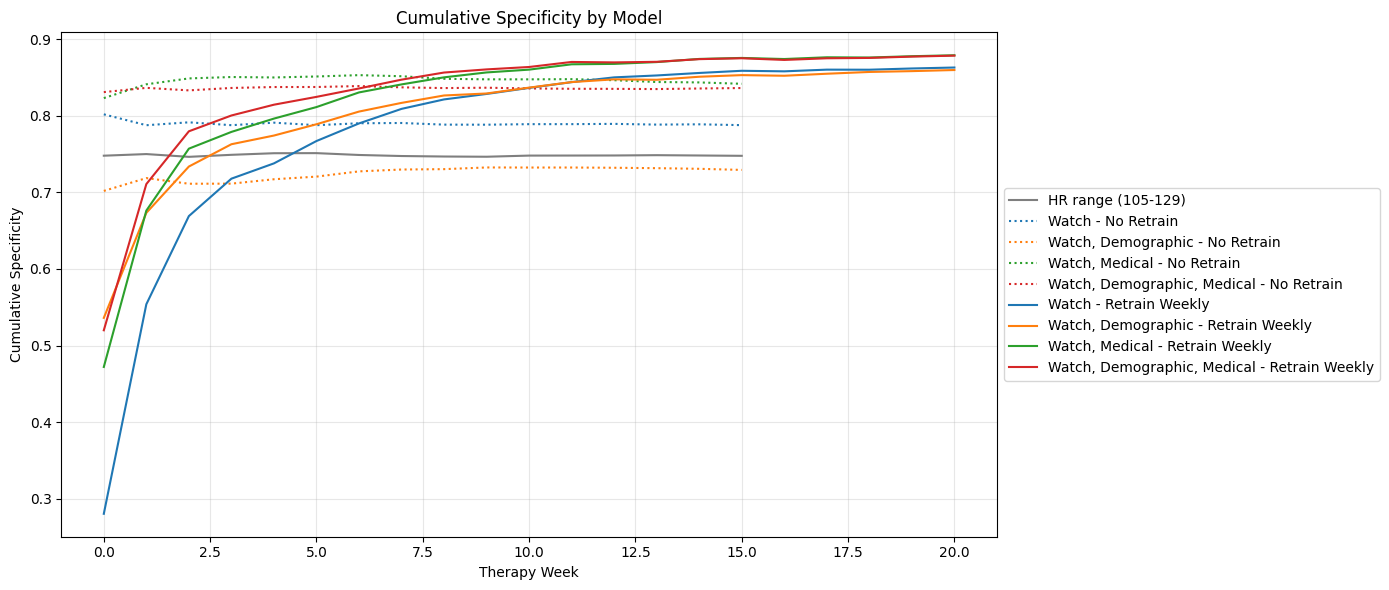

In [103]:
import matplotlib.pyplot as plt
import pandas as pd


def plot_weekly_cum_metric(metric_name, metric_fn):
    def weekly_cum_metric(results, metric_fn):
        metrics = []
        all_y_pred_proba = np.empty((0, 2))
        all_y_pred = np.array([])
        all_y_true = np.array([])
        for week, y_pred_proba, y_pred, y_true, _ in results:
            all_y_pred_proba = np.concatenate([all_y_pred_proba, y_pred_proba])
            all_y_pred = np.concatenate([all_y_pred, y_pred])
            all_y_true = np.concatenate([all_y_true, y_true])

            if metric_fn is roc_auc_score:
                metric = metric_fn(all_y_true, all_y_pred_proba[:, 1])
            else:
                metric = metric_fn(all_y_true, all_y_pred)
            metrics.append((week, metric))
        return metrics

    hr_cum_auc = weekly_cum_metric(hr_model_results, metric_fn)
    no_retrain_watch_cum_auc = weekly_cum_metric(no_retrain_results["watch"], metric_fn)
    no_retrain_demographic_cum_auc = weekly_cum_metric(
        no_retrain_results["watch_demographic"], metric_fn
    )
    no_retrain_medical_metric = weekly_cum_metric(
        no_retrain_results["watch_medical"], metric_fn
    )
    no_retrain_all_features_metric = weekly_cum_metric(
        no_retrain_results["watch_demographic_medical"], metric_fn
    )
    retrain_watch_cum_auc = weekly_cum_metric(retrain_dyad_results["watch"], metric_fn)
    retrain_demographic_cum_auc = weekly_cum_metric(
        retrain_dyad_results["watch_demographic"], metric_fn
    )
    retrain_medical_metric = weekly_cum_metric(
        retrain_dyad_results["watch_medical"], metric_fn
    )
    retrain_medical_cum_auc = weekly_cum_metric(
        retrain_dyad_results["watch_demographic_medical"], metric_fn
    )

    plt.figure(figsize=(14, 6))
    if metric_fn is roc_auc_score:
        plt.ylim(0.5, 1)
    plt.plot(*zip(*hr_cum_auc), label="HR range (105-129)", color="tab:grey")

    plt.plot(*zip(*no_retrain_watch_cum_auc), label="Watch - No Retrain", linestyle=":")
    plt.plot(
        *zip(*no_retrain_demographic_cum_auc),
        label="Watch, Demographic - No Retrain",
        linestyle=":",
    )
    plt.plot(
        *zip(*no_retrain_medical_metric),
        label="Watch, Medical - No Retrain",
        linestyle=":",
    )
    plt.plot(
        *zip(*no_retrain_all_features_metric),
        label="Watch, Demographic, Medical - No Retrain",
        linestyle=":",
    )

    plt.plot(
        *zip(*retrain_watch_cum_auc), label="Watch - Retrain Weekly", color="tab:blue"
    )

    plt.plot(
        *zip(*retrain_demographic_cum_auc),
        label="Watch, Demographic - Retrain Weekly",
        color="tab:orange",
    )
    plt.plot(
        *zip(*retrain_medical_metric),
        label="Watch, Medical - Retrain Weekly",
        color="tab:green",
    )
    plt.plot(
        *zip(*retrain_medical_cum_auc),
        label="Watch, Demographic, Medical - Retrain Weekly",
        color="tab:red",
    )

    plt.xlabel("Therapy Week")
    plt.ylabel(f"Cumulative {metric_name}")
    plt.title(f"Cumulative {metric_name} by Model")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def get_final_metrics():
    def get_final_metric(results, metric_fn):
        all_y_pred_proba = np.empty((0, 2))
        all_y_pred = np.array([])
        all_y_true = np.array([])
        for _, y_pred_proba, y_pred, y_true, _ in results:
            all_y_pred_proba = np.concatenate([all_y_pred_proba, y_pred_proba])
            all_y_pred = np.concatenate([all_y_pred, y_pred])
            all_y_true = np.concatenate([all_y_true, y_true])
        if metric_fn is roc_auc_score:
            return metric_fn(all_y_true, all_y_pred_proba[:, 1])
        else:
            return metric_fn(all_y_true, all_y_pred)

    models = [
        ("HR range (105-129)", hr_model_results),
        ("Watch - No Retrain", no_retrain_results["watch"]),
        (
            "Watch, Demographic - No Retrain",
            no_retrain_results["watch_demographic"],
        ),
        ("Watch, Medical - No Retrain", no_retrain_results["watch_medical"]),
        (
            "Watch, Demographic, Medical - No Retrain",
            no_retrain_results["watch_demographic_medical"],
        ),
        ("Watch - Retrain Weekly", retrain_dyad_results["watch"]),
        (
            "Watch, Demographic - Retrain Weekly",
            retrain_dyad_results["watch_demographic"],
        ),
        ("Watch, Medical - Retrain Weekly", retrain_dyad_results["watch_medical"]),
        (
            "Watch, Demographic, Medical - Retrain Weekly",
            retrain_dyad_results["watch_demographic_medical"],
        ),
    ]
    # Collect metrics into a DataFrame and print as markdown

    rows = []
    for name, results in models:
        auroc = get_final_metric(results, roc_auc_score)
        sensitivity = get_final_metric(results, recall_score)
        specificity = get_final_metric(results, specificity_score)
        rows.append(
            {
                "Model": name,
                "AUROC": round(auroc, 3),
                "Sensitivity": round(sensitivity, 3),
                "Specificity": round(specificity, 3),
            }
        )
    return pd.DataFrame(rows).set_index("Model")


print(get_final_metrics())
plot_weekly_cum_metric("AUROC", roc_auc_score)
plot_weekly_cum_metric("Sensitivity", recall_score)
plot_weekly_cum_metric("Specificity", specificity_score)

In [57]:
# How much can we improve the HR range model

import itertools

from sklearn.metrics import roc_auc_score

from hr_model import HrModel

full_df = pd.concat(list(cleaned_dyads_dfs.values()), axis=1)
full_df = full_df[full_df["therapy_week"].between(weeks[0], weeks[1])]
full_df_train = full_df[full_df["Arm_Sham"]]
full_df_test = full_df[~full_df["Arm_Sham"]]

X_train, y_train = prep_X_y(full_df_train, "tantrum_within_60m")

best_auc = -1
best_hr_low = None
best_hr_high = None
best_sens = None
best_spec = None

hr_lows = range(50, 150, 2)
hr_highs = range(100, 200, 2)

for combo in tqdm(list(itertools.product(hr_lows, hr_highs))):
    hr_low, hr_high = combo

    if hr_high <= hr_low:
        continue
    # Predict using HR range
    y_pred = (
        (full_df_train["hr_moving_avg_10m"] >= hr_low)
        & (full_df_train["hr_moving_avg_10m"] <= hr_high)
    ).astype(int)
    y_true = y_train

    # Only evaluate where hr_moving_avg_10m is not NaN
    mask = full_df_train["hr_moving_avg_10m"].notna()
    if mask.sum() == 0:
        continue

    auc = roc_auc_score(y_true[mask], y_pred[mask])
    sens = recall_score(y_true[mask], y_pred[mask])
    spec = specificity_score(y_true[mask], y_pred[mask])

    if auc > best_auc:
        best_auc = auc
        best_hr_low = hr_low
        best_hr_high = hr_high
        best_sens = sens
        best_spec = spec

print(f"Best HR range: {best_hr_low}-{best_hr_high}")
print(f"ROC-AUC: {best_auc:.3f}")
print(f"Sensitivity: {best_sens:.3f}")
print(f"Specificity: {best_spec:.3f}")

  0%|          | 0/2500 [00:00<?, ?it/s]

Best HR range: 92-126
ROC-AUC: 0.671
Sensitivity: 0.805
Specificity: 0.537
